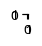

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

In [12]:
m = get_model('../output/240404_FirstBestLast_comparison/mmvaes/240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_IzcVOH/',
             map_location='cpu')

Reloading best model:
epoch: 669
total: 0.24167719816201078
recon_marg: 0.058951238294695785
recon_joint: 0.06029103156074707
kld_marg: 2.8083470404482448e-05
kld_joint: 0.12240684622103679
tcr_marg_seq_accuracy: 0.48559725284576416
tcr_joint_seq_accuracy: 0.47769173979759216
pep_joint_seq_accuracy: 0.7373113036155701
pep_marg_seq_accuracy: 0.7518730163574219
wmean_seq_accuracy: 0.5605287954211235


In [13]:
m.marg_tcr_encoder.fc_mu.weight

Parameter containing:
tensor([[-0.0234, -0.0240, -0.0243,  ..., -0.0913,  0.0766, -0.0122],
        [ 0.0262, -0.0297, -0.0392,  ..., -0.0189,  0.0290,  0.0296],
        [ 0.0534,  0.0113,  0.0441,  ..., -0.0369,  0.0056,  0.0679],
        ...,
        [-0.0130, -0.0035, -0.0013,  ..., -0.0443, -0.0467,  0.0410],
        [ 0.0399, -0.0081, -0.0445,  ..., -0.0227,  0.0327, -0.0109],
        [-0.0134, -0.0050,  0.0271,  ...,  0.0510,  0.0298,  0.0463]],
       requires_grad=True)